In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from xgboost import XGBRFClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.tree import export_graphviz
# import graphviz

import multiprocessing

import warnings

/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dir        = "DATA/"
file1      = 'BHBH_Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)
BHBH.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
BHBH.head()

,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,RemnantType_0,Mass_1,...,Events,EventsPlus,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay
0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,6,21.09631,...,RB:RE:S:RB:RE:S,RB:RE:ehSt:RB:RE:erSt,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11
1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,6,51.78028,...,S:S,hhS:hrS,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14
2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,6,30.83786,...,RB:RE:RB:RE:S:RB:RE:S,RB:RE:RB:RE:ehSt:RB:RE:erSt,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10
3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,6,33.31328,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12
4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,6,45.91471,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11


In [6]:
#X = BHBH.drop(['Index', 'ID', 'name', 'Delay_Time',
#               'Eccentricity_Delay',
#               'Events', 'EventsAll', 'EventsPlus'], axis=1).to_numpy()

# define attributes based on knowledge
# should we use the others?
X = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y = BHBH.Delay_Time.to_numpy()

In [7]:
# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.7, random_state=0)
X_train

array([[4.517758e+01, 2.942937e+01, 2.474364e+02, 2.217053e-01,
        1.000000e-04, 3.000000e+00],
       [2.040300e+01, 1.735221e+01, 6.150462e+04, 2.778844e-01,
        1.400000e-02, 5.000000e+00],
       [2.022043e+01, 2.135752e+01, 5.001095e+01, 1.319186e-02,
        6.000000e-04, 5.000000e+00],
       ...,
       [3.273191e+01, 2.267255e+01, 3.502999e+02, 2.903056e-01,
        1.000000e-04, 3.000000e+00],
       [1.374775e+01, 5.700543e+00, 8.896309e+01, 2.752416e-01,
        4.000000e-03, 5.000000e-01],
       [9.183860e+00, 9.479400e+00, 1.243541e+01, 8.879470e-02,
        2.000000e-03, 5.000000e+00]])

## Scikit-learn Random Forest

In [5]:
# model definition for the regressor
# using mostly the default parameters
#regressor=RandomForestRegressor(n_estimators=10, criterion='squared_error',
#                                max_depth=10, min_samples_split=2,
#                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
#                                max_features=1.0, max_leaf_nodes=None,
#                                min_impurity_decrease=.0, bootstrap=True,
#                                oob_score=False, n_jobs=-1,
#                                random_state=0,
#                                verbose=1)
regressor=RandomForestRegressor(n_estimators = 100, random_state = 42,
                                n_jobs=-1, verbose=3)

In [6]:
# traininig of the model
regressor.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=3)

In [7]:
# make predictions to compare with Y_test
Y_pred = regressor.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.2s finished


In [8]:
print('Score of the regressor for the training set:\n', regressor.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test,  Y_test ))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.6s finished


Score of the regressor for the training set:
 0.9998058963433247


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.9s



Score of the regressor for the test set:
 0.8661214249569875


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.6s finished


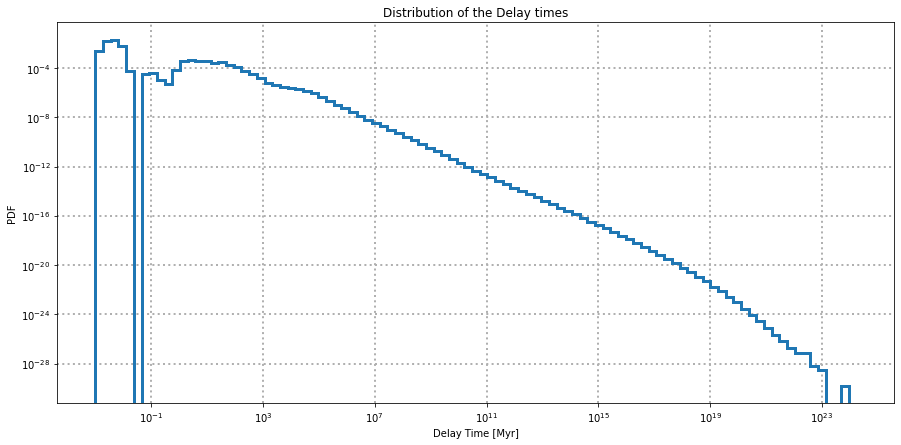

In [9]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_pred)), np.log10(max(Y_pred)), 100)
entries, edges, _ = ax.hist(Y_pred, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

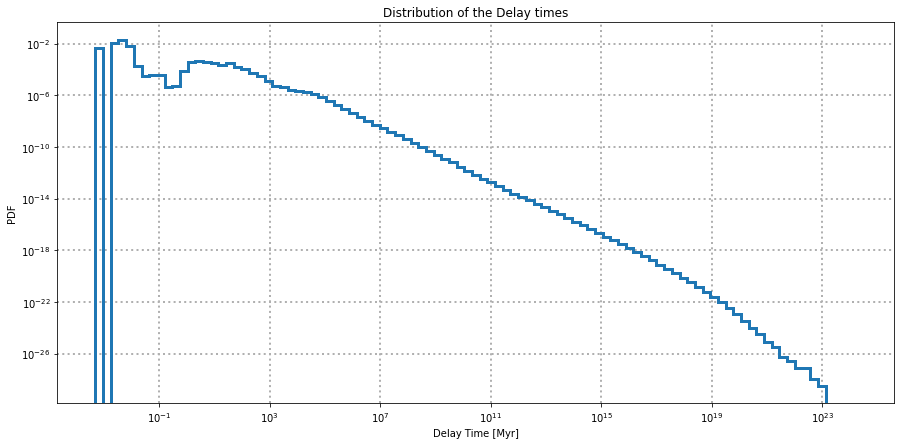

In [10]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_test)), np.log10(max(Y_test)), 100)
entries, edges, _ = ax.hist(Y_test, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

In [ ]:
dot_data = export_graphviz(regressor.estimators_[0],
                           feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],  
                           filled=True, rounded=True)  

graph = graphviz.Source(dot_data, format='png')
graph.render("tree") 

From here it is problematic: using 100 as number of trees and using 30% of the data results in using already almost all the ram (16Gb).

## Tuning of the hyperparameters
First we do a random grid search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 20, cv = 3, verbose=3, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

In [ ]:
def evaluate_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_accuracy(best_random, X_test, Y_test)

In [ ]:
best_random

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

### Using Tensorflow

In [117]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes

In [118]:
"""### Normalization over the whole dataset

features_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

min_value = np.min (np.min (features_all, axis=0))
max_value = np.max (np.max (features_all, axis=0))
avg_value = np.mean(np.mean(features_all, axis=0))
std_value = np.std (np.std (features_all, axis=0))

method = 'norm'  #norm, std, log

def normalizer(x):
    if method == 'norm':
        return (x-min_value)/(max_value-min_value)
    elif method =='std':
        return (x- avg_value)/std_value
    elif method =='log':
        return np.log10(x)

features_all = features_all.apply(normalizer)"""

"### Normalization over the whole dataset\n\nfeatures_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]\n\nmin_value = np.min (np.min (features_all, axis=0))\nmax_value = np.max (np.max (features_all, axis=0))\navg_value = np.mean(np.mean(features_all, axis=0))\nstd_value = np.std (np.std (features_all, axis=0))\n\nmethod = 'norm'  #norm, std, log\n\ndef normalizer(x):\n    if method == 'norm':\n        return (x-min_value)/(max_value-min_value)\n    elif method =='std':\n        return (x- avg_value)/std_value\n    elif method =='log':\n        return np.log10(x)\n\nfeatures_all = features_all.apply(normalizer)"

### Normalization of the data

In [119]:
### Normalization of each column

features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

# min-max normalization
features = (features-features.min())/(features.max()-features.min())

# mean normalization
#features=(features-features.mean())/features.std()

### Split in training and validation

In [120]:
# Split the dataset into a training and a testing dataset.
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [121]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=features,
                                        test_ratio=.5)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

1027189 examples in training, 1027851 examples for testing.


In [122]:
X_train = train_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_train = train_ds_pd.Delay_Time.to_numpy()

X_test  = test_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_test  = test_ds_pd.Delay_Time.to_numpy()

/home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


### Definition of the hyperparameters

In [138]:
# Maximum number of decision trees. The effective number of trained trees can be smaller if early stopping is enabled.
NUM_TREES = 250
# Minimum number of examples in a node.
MIN_EXAMPLES = 6
# Maximum depth of the tree. max_depth=1 means that all trees will be roots.
MAX_DEPTH = 5
# Ratio of the dataset (sampling without replacement) used to train individual trees for the random sampling method.
SUBSAMPLE = 0.65
# Control the sampling of the datasets used to train individual trees.
SAMPLING_METHOD = "RANDOM"
# Ratio of the training dataset used to monitor the training. Require to be >0 if early stopping is enabled.
VALIDATION_RATIO = 0.1
# Name of the label column.
label = "Delay_Time"

### Training of the model

In [141]:
def run_experiment(model, train_data, test_data, label='Delay_Time', num_epochs=1, batch_size=None):
    
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label, task=tfdf.keras.Task.REGRESSION)
    test_ds  = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label, task=tfdf.keras.Task.REGRESSION)
    
    with sys_pipes():
        model.fit(train_ds, epochs=num_epochs, batch_size=batch_size)
        _, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [142]:
# Configure the model.
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Configure the metrics (Eventually add other metrics).
#model.compile(metrics=["mse", "mape"])
#model.compile(metrics=["mse"])
# Train the model.
#with sys_pipes():
    #model.fit(x=train_ds)
#    model.fit(X_train, Y_train)

run_experiment(model=model, train_data=train_ds_pd, test_data=test_ds_pd)

Use /tmp/tmpqihos272 as temporary training directory


/home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


Reading training dataset...
Training dataset read in 0:00:03.438828. Found 1027189 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmpqihos272/model/ with prefix 2b66b537bb494977
[INFO abstract_model.cc:1246] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Model trained in 0:02:09.643045
Compiling model...
Model compiled.


TypeError: cannot unpack non-iterable float object

In [125]:
model.summary()

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	data:0.0
	data:0.1
	data:0.2
	data:0.3
	data:0.4
	data:0.5

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL" 13.937913 ################
    2. "data:0.5" 13.756575 ###############
    3. "data:0.1"  7.956152 ########
    4. "data:0.3"  5.382036 #####
    5. "data:0.4"  3.618377 ##
    6. "data:0.0"  2.998903 ##
    7. "data:0.2"  1.275012 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 124.000000 ################
    2. "data:0.2" 117.000000 ###############
    3. "data:0.3" 40.000000 ####
    4. "data:0.4" 14.000000 #
    5. "data:0.1"  5.000000 

Variable Importance: NUM_NODES:
    1. "data:0.2" 1292

In [91]:
# inspect the features used in the model
model.make_inspector().features()

["Eccentricity" (1; #0),
 "Mass_0" (1; #1),
 "Mass_1" (1; #2),
 "Semimajor" (1; #3),
 "Z" (1; #4),
 "alpha" (1; #5)]

In [93]:
#evaluation = model.evaluate(test_ds, return_dict=True)
evaluation = model.evaluate(X_test, Y_test, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {np.sqrt(evaluation['mse']):.2f}")
#print(f"MAPE: {evaluation['mape']:.2f}")

1028/1028 [==============================] - 22s 21ms/step - loss: 0.0000e+00 - mse: 8.9343e-07
{'loss': 0.0, 'mse': 8.934292168305547e-07}
MSE: 0.00
RMSE: 0.00


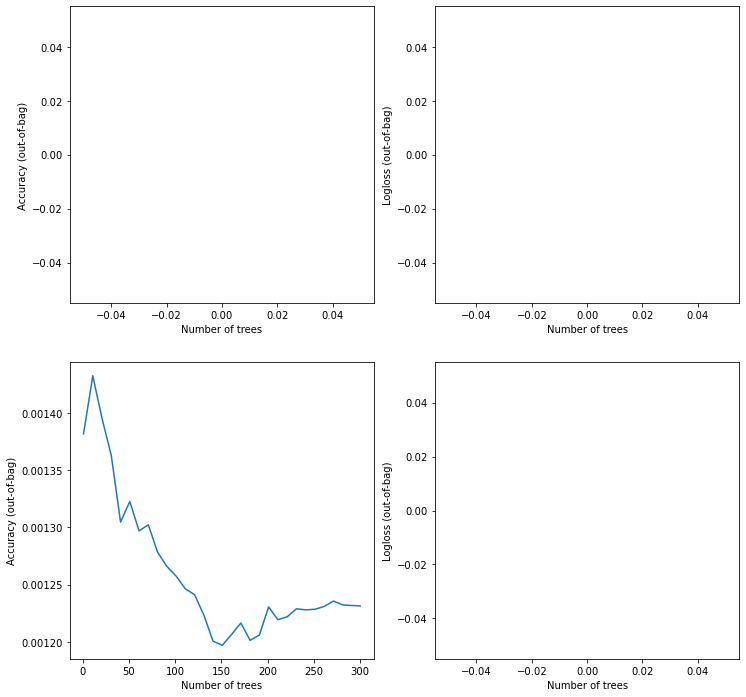

In [94]:
logs = model.make_inspector().training_logs()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12, 12))

ax[0,0].plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
ax[0,0].set_xlabel("Number of trees")
ax[0,0].set_ylabel("Accuracy (out-of-bag)")
ax[0,1].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
ax[0,1].set_xlabel("Number of trees")
ax[0,1].set_ylabel("Logloss (out-of-bag)")
ax[1,0].plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
ax[1,0].set_xlabel("Number of trees")
ax[1,0].set_ylabel("Accuracy (out-of-bag)")
ax[1,1].plot([log.num_trees for log in logs], [log.evaluation.ndcg for log in logs])
ax[1,1].set_xlabel("Number of trees")
ax[1,1].set_ylabel("Logloss (out-of-bag)")
plt.show()


# ????
# Why loss and accuracy are zero?
# Maybe something missing

In [96]:
# make predictions to compare with Y_test
#Y_pred = model.predict(test_ds)
Y_pred = model.predict(X_test)

1028/1028 [==============================] - 21s 21ms/step


In [114]:
epsilon = 1e-28

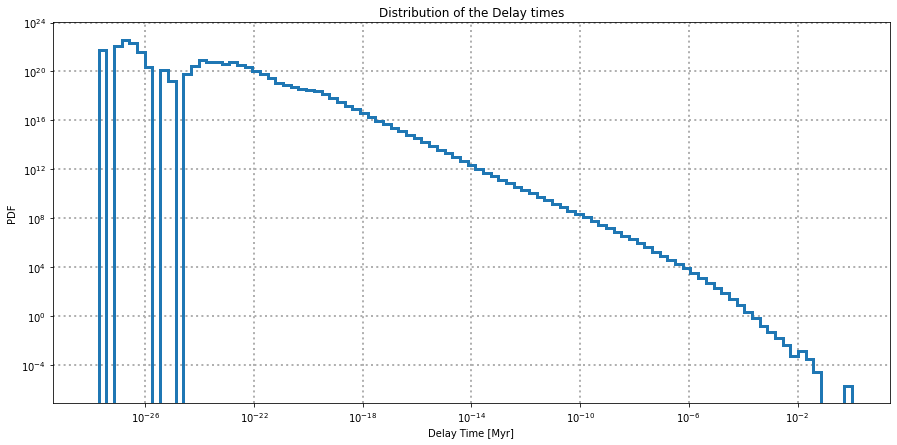

In [115]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_test)+epsilon), np.log10(max(Y_test)), 100)
entries, edges, _ = ax.hist(Y_test, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

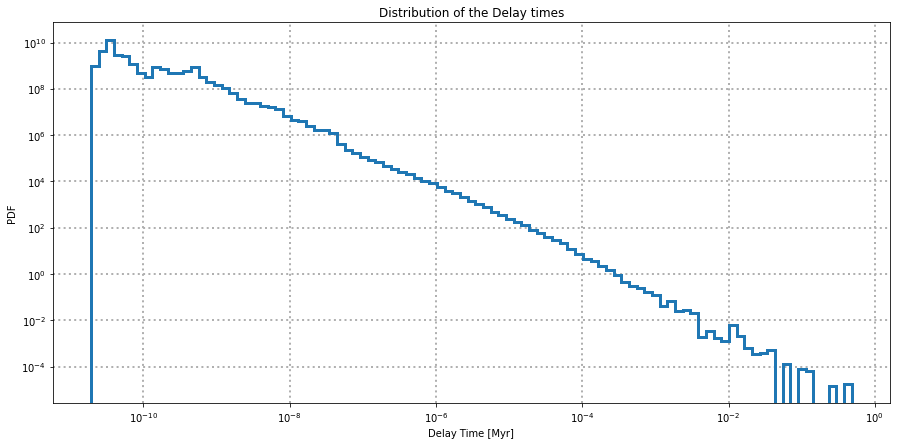

In [100]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_pred)), np.log10(max(Y_pred)), 100)
b = np.concatenate(b, axis=0)
entries, edges, _ = ax.hist(Y_pred, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

In [116]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_c9f9d4664ba8485d95fb6fd50270894f"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

In [3]:
"""for deeptnote"""
# def slice_dataset(dataset, slice_ratio=0.15):
#   valid_indices = np.random.rand(len(dataset)) < slice_ratio
#   return dataset[valid_indices]
# BHBH_sliced = slice_dataset(BHBH)
# BHBH_sliced.to_csv('dataset.csv')